# Open-Neural-APC as Tensorflow 2 implementation

In [1]:
# install and upgrade required packages
!pip3 install --upgrade tensorflow
!pip3 install --upgrade matplotlib
!pip3 install --upgrade numpy

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/site-packages (2.1.0)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/site-packages (3.2.0)
Requirement already up-to-date: numpy in /usr/local/lib/python3.7/site-packages (1.18.1)


In [2]:
# load model config
import json
with open('config.json', 'r') as config_file:
    config_data = json.load(config_file)

# extract parameter classes
data_parameter = config_data['data parameter']
model_parameter = config_data['model parameter']
training_parameter = config_data['training parameter']

# show content of config
config_data

{'data parameter': {'data directory': './data/',
  'training labels': 'labels/',
  'training csv': 'csv/',
  'training label': 'train.csv',
  'validation labels': 'labels_public/',
  'validation csv': 'csv_public/',
  'validation label': 'valid.csv'},
 'model parameter': {'input dimensions': [20, 25],
  'lstm width': 50,
  'lstm depth': 5,
  'output dimensions': 2},
 'training parameter': {'epochs': 10000,
  'safe steps': 5,
  'pretrain': False,
  'batchsize': 16,
  'learning rate': 0.001,
  'dropout rate': 0.2,
  'jump input frames': 4,
  'accuracy error niveau': 0.5}}

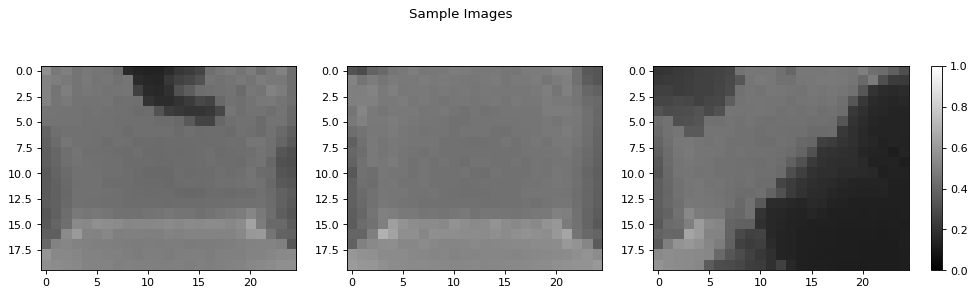

In [3]:
# inspect the data

# plot n sample images
def plotNRandomSampleImages(n=3):
    import glob
    from matplotlib import pyplot as plt
    %matplotlib inline
    import csv
    import random
    import numpy as np

    # restrict to a few plots
    if n < 2 or n > 5:
        raise ValueError('Restricted to only 2 to 5 plots at a time.')
    
    # get path of all csv files in folder
    validation_csv_path = glob.glob(f"{data_parameter['data directory']}{data_parameter['validation csv']}*.csv")
                                    
    # prepare plot
    fig, ax = plt.subplots(1,n,figsize=(14,6), dpi=80)
    fig.suptitle('Sample Images')
    fig.subplots_adjust(top=1.5-(1./n)) # just a hack
                                    
    # iterate n times and always choose random file and random frame
    for idx in range(n):
        with open(random.choice(validation_csv_path), 'r') as csv_file:
            picture_iterator = list(csv.reader(csv_file))
            frame = random.choice(picture_iterator)
            # reshape, rescale and plot image
            frame = np.reshape(frame,model_parameter['input dimensions'])
            frame = np.asarray(frame,dtype=int)/255.                    
            ax[idx].imshow(frame,cmap="gray",vmin=0,vmax=1)
                                    
    # add colorbar for pixel range
    cax = fig.add_axes([ax[-1].get_position().x1+0.02,ax[-1].get_position().y0,0.01,ax[-1].get_position().y1-ax[-1].get_position().y0])
    fig.colorbar(*ax[-1].get_images(), cax = cax)
    plt.show(fig)

plotNRandomSampleImages()

In [4]:
# create network
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
from tensorflow.keras.layers import Reshape,InputLayer,LSTM,Dense,LeakyReLU

# initial definition of the sequential model
model = keras.Sequential()
model.add(InputLayer(input_shape=[None,*model_parameter['input dimensions']]))
# input layer which is currently just a dense layer, therefore we have to flatten the input frames
def Input():
    model.add(Reshape(target_shape=(-1, np.multiply(*model_parameter['input dimensions'])),name='InputReshape'))
    model.add(Dense(model_parameter['lstm width'],trainable=True,name='InputLayer'))
    model.add(LeakyReLU(name='InputActivation'))
# the core network based on lstm
def Core():
    for idx in range(model_parameter['lstm depth']):
        model.add(LSTM(units=model_parameter['lstm width'], dropout=training_parameter['dropout rate'],\
                        return_sequences=True,name='CoreLayer%d'%idx))
# the output layer just reducing the dimensionality to the regression output
def Output():
    model.add(Dense(model_parameter['output dimensions'],name='OutputLayer'))
    model.add(LeakyReLU(-1,name='OutputActivation'))
# assemble network
Input()
Core()
Output()
# print the model properties
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputReshape (Reshape)       (None, None, 500)         0         
_________________________________________________________________
InputLayer (Dense)           (None, None, 50)          25050     
_________________________________________________________________
InputActivation (LeakyReLU)  (None, None, 50)          0         
_________________________________________________________________
CoreLayer0 (LSTM)            (None, None, 50)          20200     
_________________________________________________________________
CoreLayer1 (LSTM)            (None, None, 50)          20200     
_________________________________________________________________
CoreLayer2 (LSTM)    

In [5]:
# define loss
import tensorflow.keras.backend as K

def loss(upper_bound,lower_bound,prediction):
    mask = K.minimum(0.,upper_bound)+1.
    error = mask * (K.maximum(0.,prediction-upper_bound) +\
                        K.minimum(0.,prediction-lower_bound))
    return error
    
def customLoss(y_true, y_pred):
    output_dimensions = model_parameter['output dimensions']
    upper_bound = y_true[:,:,:output_dimensions]
    lower_bound = y_true[:,:,output_dimensions:2*output_dimensions]
    return loss(upper_bound,lower_bound,y_pred)

optimizer = keras.optimizers.Adam(training_parameter['learning rate'])
model.compile(loss=customLoss, optimizer=optimizer)

In [6]:
# prepare data

In [7]:
# train

In [8]:
# evaluate